# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
from scipy import ndimage
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import matplotlib.gridspec as gridspec
import random

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(train_features)

# TODO: number of testing examples
n_test = len(test_features)

# TODO: what's the shape of an image?
image_shape = train_features.shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(test_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [3]:
#Print the 43 class label names
signname_map = np.genfromtxt('signnames.csv', skip_header=1, delimiter=',', usecols=(1,), unpack=True, dtype=str)


# Use the mapping array to print the SignName.
predictions = np.unique(test_labels)
predict_signNames = []
for id in predictions:
    predict_signNames.append(signname_map[int(id)])
print(predict_signNames)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vechiles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vechiles over 3.5 metric tons']


Sample test images: 100%|██████████| 43/43 [01:06<00:00,  1.56s/labels]


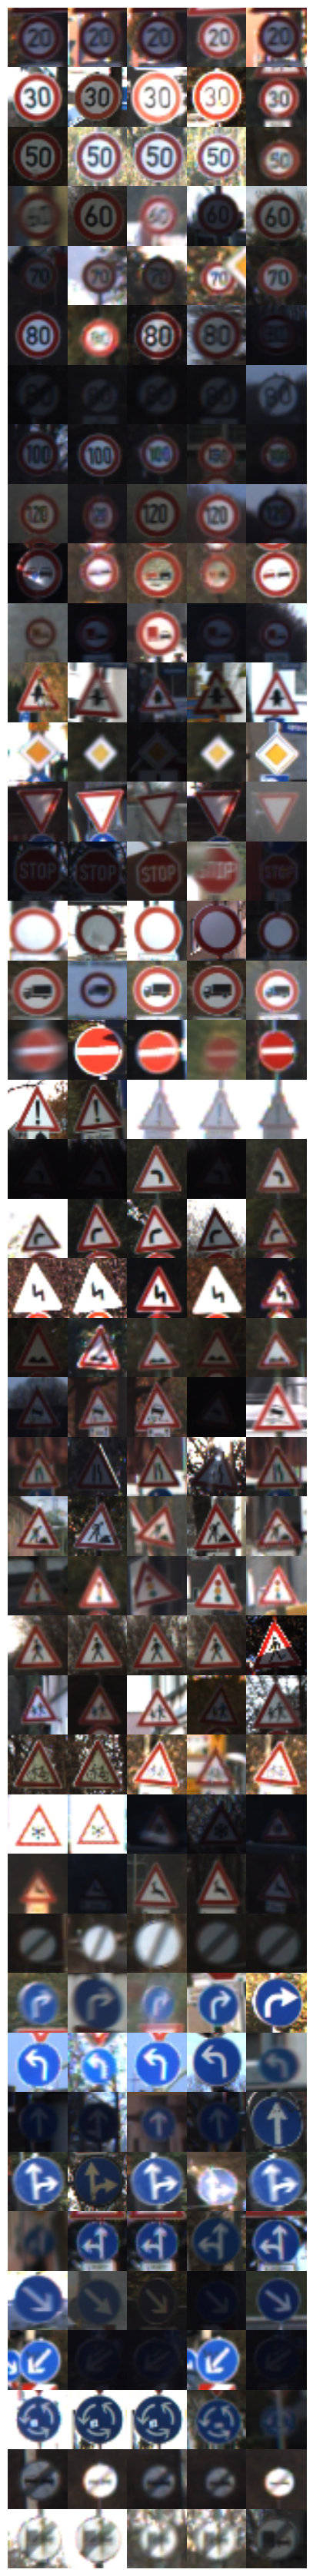

In [4]:
# This print routine was written by my October cohort John Chen and posted on Atlassian
# Using the test data five samples for each of the Forty three classes are plotted
sample_size = 5 #five image per class label
n_labels = 43
count = 0 #book keeping for plots
fig = plt.figure(figsize=(sample_size, n_labels))
grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')
for i in labelset_pbar:
    ind = test_labels == i
    subset_x =test_features [ind,] #get all images that belong to class i
    for x in range(sample_size):
        img = random.choice(subset_x) #randomly pick on image from class i
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        fig.add_subplot(ax)
        count +=1

    # hide the borders
    if i == (n_labels-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plt.show()

In [5]:
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

In [6]:
#Implement Min-Max scaling for image data
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

if not is_features_normal:
    train_features = normalize(train_features)
    test_features = normalize(test_features)
    is_features_normal = True

print('Tests Passed!')



Tests Passed!


In [7]:
from sklearn.preprocessing import OneHotEncoder

def OHE_labels(Y_t,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_t.reshape(-1, 1)).toarray()
    
    return Y_labels


train_labels = OHE_labels(train_labels,43)
test_labels = OHE_labels(test_labels,43)
is_labels_encod = True
print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [8]:
#flatten test and train features
train_features = train_features.reshape(-1, 32*32*3)
test_features = test_features.reshape(-1, 32*32*3)
train_features = train_features.reshape(-1, 32*32*3)

In [9]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=0)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [10]:
#Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
train_features = train_features.astype(np.float32)
test_features = test_features.astype(np.float32)
valid_features = valid_features.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

In [11]:
### Data exploration visualization goes here.


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
features_count = 32*32*3
labels_count = 43

#Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# Problem 2 - Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))


In [13]:
#Error detection section
#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, features_count]), 'The shape of features is incorrect'
assert labels._shape in [None, labels_count], 'The shape of labels is incorrect'
assert weights._variable._shape == (features_count, labels_count), 'The shape of weights is incorrect'
assert biases._variable._shape == (labels_count), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

In [14]:
# Feed dicts for training, validation, and test session#valid_feed_dict = {features: valid_features, labels: valid_labels}

train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy

cross_entropy = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), 
                                              reduction_indices=[1]))


# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

In [15]:
loss

<tf.Tensor 'Mean_1:0' shape=<unknown> dtype=float32>

In [16]:
labels

<tf.Tensor 'Placeholder_1:0' shape=<unknown> dtype=float32>

In [17]:
features

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=float32>

In [18]:
# Test Cases
with tf.Session() as session:
    session.run(init) 
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [19]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


### Question 1 

_Describe the techniques used to preprocess the data._

Epoch  2/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.29270780086517334 Training accuracy at 0.3034793734550476


Epoch  3/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.5629780888557434 Training accuracy at 0.5860717296600342


Epoch  4/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.6782253980636597 Training accuracy at 0.701541006565094


Epoch  5/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.7287098169326782 Training accuracy at 0.7570339441299438


Epoch  6/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.7312595844268799 Training accuracy at 0.7588595151901245


Epoch  7/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.7623661160469055 Training accuracy at 0.7873174548149109


Epoch  8/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.7628760933876038 Training accuracy at 0.7877201437950134


Epoch  9/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8006119132041931 Training accuracy at 0.8196413516998291


Epoch  9/100: 100%|██████████| 1863/1863 [00:39<00:00, 47.47batches/s]


Validation accuracy at 0.8164201974868774 Training accuracy at 0.836259663105011


Epoch 11/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8072412014007568 Training accuracy at 0.8395349979400635


Epoch 12/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8133605122566223 Training accuracy at 0.8441795706748962


Epoch 13/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.825599193572998 Training accuracy at 0.8482602834701538


Epoch 14/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8230494856834412 Training accuracy at 0.8485556244850159


Epoch 15/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8261091113090515 Training accuracy at 0.8533344268798828


Epoch 16/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8266190886497498 Training accuracy at 0.8591870665550232


Epoch 17/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8597654104232788 Training accuracy at 0.8860610127449036


Epoch 18/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8475267887115479 Training accuracy at 0.8788928389549255


Epoch 19/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.854665994644165 Training accuracy at 0.8836715817451477


Epoch 20/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.854665994644165 Training accuracy at 0.8854166865348816


Epoch 21/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8674145936965942 Training accuracy at 0.8970683217048645


Epoch 22/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8755736947059631 Training accuracy at 0.9061694741249084


Epoch 23/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8750637173652649 Training accuracy at 0.9040753841400146


Epoch 24/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8827129006385803 Training accuracy at 0.9138745665550232


Epoch 24/100: 100%|██████████| 1863/1863 [00:38<00:00, 47.96batches/s]


Validation accuracy at 0.8776134848594666 Training accuracy at 0.9089347124099731


Epoch 26/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8878123164176941 Training accuracy at 0.9192708134651184


Epoch 27/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8888322114944458 Training accuracy at 0.9198077917098999


Epoch 28/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8867924809455872 Training accuracy at 0.9221166372299194


Epoch 29/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8908720016479492 Training accuracy at 0.9223850965499878


Epoch 30/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8867924809455872 Training accuracy at 0.9234052896499634


Epoch 31/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8873023986816406 Training accuracy at 0.9235395193099976


Epoch 32/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8873023986816406 Training accuracy at 0.9259288907051086


Epoch 33/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8908720016479492 Training accuracy at 0.9264658689498901


Epoch 34/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8867924809455872 Training accuracy at 0.925875186920166


Epoch 35/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8903620839118958 Training accuracy at 0.9280498027801514


Epoch 36/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8929117918014526 Training accuracy at 0.9299291372299194


Epoch 37/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8913819193840027 Training accuracy at 0.9283183217048645


Epoch 38/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8929117918014526 Training accuracy at 0.9317815899848938


Epoch 39/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8954614996910095 Training accuracy at 0.932237982749939


Epoch 40/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.894951581954956 Training accuracy at 0.9332044720649719


Epoch 41/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8929117918014526 Training accuracy at 0.9322111010551453


Epoch 42/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8924018144607544 Training accuracy at 0.9331239461898804


Epoch 43/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8924018144607544 Training accuracy at 0.933499813079834


Epoch 44/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8898521065711975 Training accuracy at 0.9318352937698364


Epoch 45/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8934217095375061 Training accuracy at 0.9335534572601318


Epoch 45/100: 100%|██████████| 1863/1863 [00:43<00:00, 42.47batches/s]


Validation accuracy at 0.8934217095375061 Training accuracy at 0.9335266351699829


Epoch 47/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8934217095375061 Training accuracy at 0.9339562058448792


Epoch 48/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.894951581954956 Training accuracy at 0.9344125986099243


Epoch 49/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8975012898445129 Training accuracy at 0.9357549548149109


Epoch 50/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8964813947677612 Training accuracy at 0.9360771179199219


Epoch 50/100: 100%|██████████| 1863/1863 [00:43<00:00, 43.08batches/s]


Validation accuracy at 0.8934217095375061 Training accuracy at 0.9358623027801514


Epoch 52/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8939316868782043 Training accuracy at 0.9355401396751404


Epoch 53/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8975012898445129 Training accuracy at 0.9361576437950134


Epoch 54/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8944416046142578 Training accuracy at 0.9369361996650696


Epoch 55/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.895971417427063 Training accuracy at 0.9372852444648743


Epoch 56/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8954614996910095 Training accuracy at 0.9370704293251038


Epoch 57/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8980112075805664 Training accuracy at 0.938439667224884


Epoch 58/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8969913125038147 Training accuracy at 0.9382517337799072


Epoch 59/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8975012898445129 Training accuracy at 0.9385738968849182


Epoch 60/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8969913125038147 Training accuracy at 0.9396746158599854


Epoch 61/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8975012898445129 Training accuracy at 0.9385470151901245


Epoch 62/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8975012898445129 Training accuracy at 0.9383322596549988


Epoch 63/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8990311026573181 Training accuracy at 0.939406156539917


Epoch 64/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8985211849212646 Training accuracy at 0.9392987489700317


Epoch 65/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8964813947677612 Training accuracy at 0.9378489851951599


Epoch 66/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8964813947677612 Training accuracy at 0.9397820234298706


Epoch 67/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.895971417427063 Training accuracy at 0.9403994679450989


Epoch 68/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8969913125038147 Training accuracy at 0.9402115345001221


Epoch 69/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8985211849212646 Training accuracy at 0.9396209120750427


Epoch 70/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8975012898445129 Training accuracy at 0.9414733648300171


Epoch 71/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8969913125038147 Training accuracy at 0.9402115345001221


Epoch 72/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8964813947677612 Training accuracy at 0.9405605792999268


Epoch 73/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8964813947677612 Training accuracy at 0.9415270686149597


Epoch 74/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8995410799980164 Training accuracy at 0.9421713948249817


Epoch 75/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9421713948249817


Epoch 76/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9020907878875732 Training accuracy at 0.9428157210350037


Epoch 77/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9010708928108215 Training accuracy at 0.9432184100151062


Epoch 78/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9436479806900024


Epoch 79/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9020907878875732 Training accuracy at 0.9437016844749451


Epoch 80/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9026007056236267 Training accuracy at 0.9438090920448303


Epoch 80/100: 100%|██████████| 1863/1863 [00:46<00:00, 49.18batches/s]


Validation accuracy at 0.901580810546875 Training accuracy at 0.9435942769050598


Epoch 82/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9442117810249329


Epoch 83/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9026007056236267 Training accuracy at 0.9446413516998291


Epoch 84/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9435942769050598


Epoch 85/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9441580772399902


Epoch 86/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.943728506565094


Epoch 87/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9442654848098755


Epoch 88/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9445607662200928


Epoch 89/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9020907878875732 Training accuracy at 0.9438090920448303


Epoch 90/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9026007056236267 Training accuracy at 0.944372832775116


Epoch 91/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.901580810546875 Training accuracy at 0.9446144700050354


Epoch 92/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9020907878875732 Training accuracy at 0.9453125


Epoch 93/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9026007056236267 Training accuracy at 0.944050669670105


Epoch 94/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9051504135131836 Training accuracy at 0.9453930258750916


Epoch 95/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9056603908538818 Training accuracy at 0.9456614851951599


Epoch 96/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9046404957771301 Training accuracy at 0.9460910558700562


Epoch 97/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9051504135131836 Training accuracy at 0.9457420706748962


Epoch 98/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9046404957771301 Training accuracy at 0.946278989315033


Epoch 99/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9056603908538818 Training accuracy at 0.9467890858650208


Epoch 100/100:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.9046404957771301 Training accuracy at 0.9469770193099976


Epoch 100/100: 100%|██████████| 1863/1863 [00:48<00:00, 38.13batches/s]


Validation accuracy at 0.907190203666687 Training accuracy at 0.9469501972198486


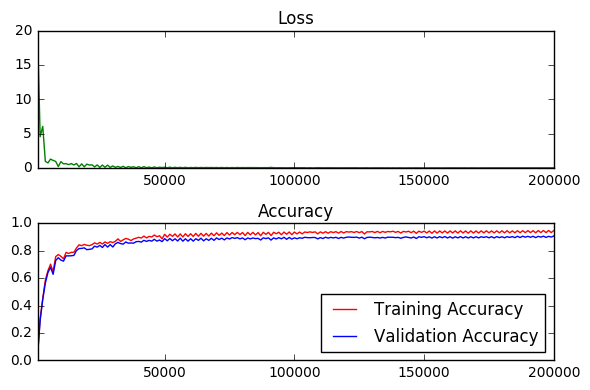

In [20]:
epochs = 100

batch_size = 20
learning_rate = .24
global batch_start
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 1000
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        print('Validation accuracy at {}'.format(validation_accuracy),'Training accuracy at {}'.format(training_accuracy) )
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

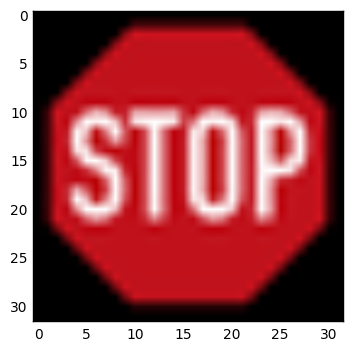

In [21]:
#Pictures 
img=Image.open('stop.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)


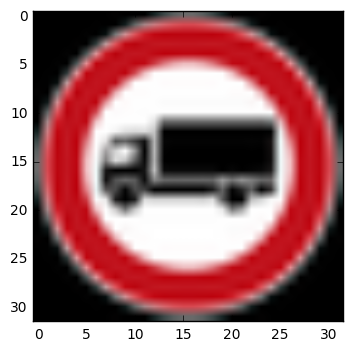

In [22]:
img=Image.open('trump.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr2 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

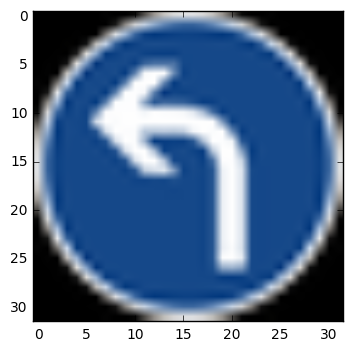

In [23]:
img=Image.open('turnleft.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr3 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)


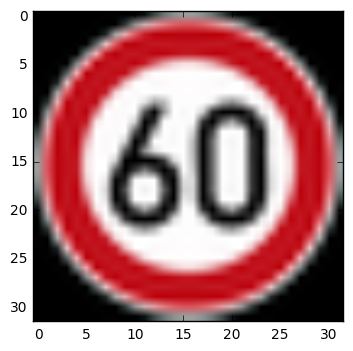

In [24]:
img=Image.open('60kmph.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr4 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

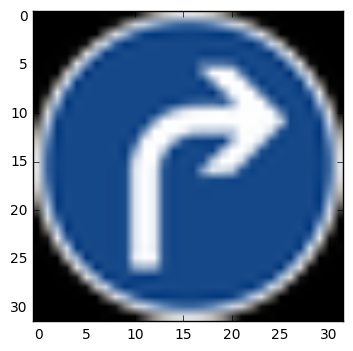

In [25]:
img=Image.open('turnright.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr5 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

In [26]:
newdata = X_tr
newdata = np.vstack([newdata, X_tr2])
newdata = np.vstack([newdata, X_tr3])
newdata = np.vstack([newdata, X_tr4])
newdata = np.vstack([newdata, X_tr5])
newdata = newdata.reshape(-1, 32*32*3)

In [27]:
# Add an op to initialize the variables.
init_op = tf.initialize_all_variables()
topFive=tf.nn.top_k(prediction, k=5, sorted=True, name=None)
top_k_feed_dict = {features: newdata}
# Run the tf.nn.top_k operation in the session

with tf.Session() as session:
    # Run the init operation.
    session.run(init_op)
    print(session.run(topFive, feed_dict = top_k_feed_dict))

TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[20,  0,  1,  2,  3],
       [33,  0,  1,  2,  3],
       [37,  0,  1,  2,  3],
       [25,  0,  1,  2,  3],
       [31,  0,  1,  2,  3]], dtype=int32))


**Answer:**

In [28]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [29]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [30]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [32]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [33]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.